# Libraries

In [1]:
! pip install transformers timm albumentations --quiet
! pip install ipywidgets --quiet

In [2]:
# Standard Libraries
import os
import random
from collections import Counter

# Numerical and Data Handling Libraries
import numpy as np
import pandas as pd

# Image Processing Libraries
import cv2
from PIL import Image

# Plotting and Visualization
import matplotlib.pyplot as plt

# PyTorch and Torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformers for Vision Models
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor

# Utility Libraries
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# jupyter nbextension enable --py widgetsnbextension
from google.colab import output
output.enable_custom_widget_manager()

# Preprocessing

In [3]:
train_dir = "/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images"

In [4]:
# Data augmentation (rotation)
train_dir = "/kaggle/input/bdma-07-competition/BDMA7_project_files/train_images"
output_dir = "/kaggle/working/preprocessed_images"

# Image processing parameters
img_size = (128, 128)  # Resize dimensions
rotation_angles = [-15, -10, -5, 5, 10, 15]  # Rotation angles

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data augmentation and saving
def preprocess_and_augment_images(input_dir, output_dir, img_size, angles):
    """
    Perform preprocessing (resize) and augmentation (rotation) on images.
    """
    for class_folder in tqdm(os.listdir(input_dir), desc="Processing Classes"):
        class_path = os.path.join(input_dir, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Create output directory for each class
        class_output_path = os.path.join(output_dir, class_folder)
        os.makedirs(class_output_path, exist_ok=True)

        # Process each image
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Unable to read image {img_path}")
                continue

            # Resize the image
            resized_img = cv2.resize(img, img_size)

            # Save the resized original image
            base_name = os.path.splitext(img_file)[0]
            cv2.imwrite(os.path.join(class_output_path, f"{base_name}_original.jpg"), resized_img)

            # Data augmentation (rotation)
            for angle in angles:
                # Calculate the rotation matrix
                h, w = resized_img.shape[:2]
                center = (w // 2, h // 2)
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

                # Rotate the image
                rotated_img = cv2.warpAffine(resized_img, rotation_matrix, (w, h))

                # Save the augmented image
                augmented_name = f"{base_name}_rotated_{angle}.jpg"
                cv2.imwrite(os.path.join(class_output_path, augmented_name), rotated_img)

# Execute preprocessing and augmentation
preprocess_and_augment_images(train_dir, output_dir, img_size, rotation_angles)

print("Data preprocessing and augmentation complete. Files saved to:", output_dir)

Processing Classes: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

Data preprocessing and augmentation complete. Files saved to: /kaggle/working/preprocessed_images


In [5]:
## Data augmentation (flip)
def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)

def main():
    train_dir = "/kaggle/working/preprocessed_images"
    output_dir = "/kaggle/working/preprocessed02_images"
    # Define a list of flip codes
    # flip_codes = [0, 1, -1]
    flip_codes = [1]

    # Iterate through subdirectories (classes) in the input directory
    for root, dirs, files in os.walk(train_dir):
        for dir_name in dirs:
            input_class_dir = os.path.join(root, dir_name)
            output_class_dir = os.path.join(output_dir, dir_name)
            # Create the output directory if it doesn't exist
            if not os.path.exists(output_class_dir):
                os.makedirs(output_class_dir)
            # Iterate through files in the class directory
            for file in os.listdir(input_class_dir):
                if file.endswith(".jpg"):
                    input_file_path = os.path.join(input_class_dir, file)
                    # Read the image
                    image = cv2.imread(input_file_path)
                    
                    # Copy the original image to the output directory
                    output_original_file_path = os.path.join(output_class_dir, file)
                    cv2.imwrite(output_original_file_path, image)
                    
                    # Generate flipped images for each flip operation
                    for flip_code in flip_codes:
                        # Generate a new file name
                        base_name = os.path.splitext(file)[0]
                        output_file_name = f"{base_name}_flipped_{flip_code}.jpg"
                        output_file_path = os.path.join(output_class_dir, output_file_name)
                        # Perform the flip operation on the image
                        flipped_image = flip_image(image, flip_code)
                        cv2.imwrite(output_file_path, flipped_image)

if __name__ == "__main__":
    main()

# Vision Transformer Model

In [6]:
train_dir = "/kaggle/working//preprocessed02_images"
val_dir = "/kaggle/input/bdma-07-competition/BDMA7_project_files/val_images"

In [7]:
model_name = "google/vit-base-patch16-224-in21k"  # 224x224 Input，16x16 Chunk
# Change to ViT-Large
# model_name = "google/vit-large-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=20,  # Number of Classes
    ignore_mismatched_sizes=True  
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# import timm
# model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=20)

## Freeze all feature layers of ViT

In [9]:
# Freeze all feature layers of ViT (train only the classification head)
for param in model.vit.parameters():
    # param.requires_grad = False
    param.requires_grad = True

# Thaw the classification headers separately
for param in model.classifier.parameters():
    param.requires_grad = True

## Set layer-wise learning rate

In [10]:
# Set layer-wise learning rate (feature layer learning rate is lower)
optimizer = AdamW(
    [
        {"params": model.vit.parameters(), "lr": 1e-5},  # Feature extraction layer
        {"params": model.classifier.parameters(), "lr": 3e-4}  # Classification Header
    ],
    weight_decay=0.01
)

In [11]:
# Verify that the classification layer is randomly initialized (correct state should be True)
print(model.classifier.weight.mean().item())  # Should be close to 0 (normal distribution initialization)
print(model.classifier.bias.mean().item())    # Should be close to 0

2.140599099220708e-05
0.0


In [12]:
submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BirdDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.dataset = ImageFolder(root=main_dir, transform=transform)
        self.class_to_idx = self.dataset.class_to_idx
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

train_dataset = BirdDataset(train_dir, transform=train_transform)
val_dataset = BirdDataset(val_dir, transform=val_transform)

def validate_class_order(train_class_order, submission_order):
    """Make sure the category names and order of both lists are exactly the same"""
    if len(train_class_order) != len(submission_order):
        raise ValueError(f"The number of categories does not match! Training set: {len(train_class_order)}, Submission Requirements: {len(submission_order)}")
    
    for train_cls, sub_cls in zip(train_class_order, submission_order):
        if train_cls != sub_cls:
            raise ValueError(f"Inconsistent order: training set '{train_cls}' vs Submission Requirements '{sub_cls}'")
    return True

train_class_order = sorted(train_dataset.class_to_idx.keys())

try:
    validate_class_order(train_class_order, submission_class_order)
except ValueError as e:
    print("Category order inconsistency detected, automatically correcting...")
    from torchvision.datasets import DatasetFolder
    
    class OrderedImageFolder(DatasetFolder):
        """Forces the data sets of categories to be loaded in a specified order"""
        def __init__(self, root, class_order, transform=None):
            self.class_order = class_order
            super().__init__(
                root,
                loader=lambda x: Image.open(x).convert("RGB"),
                extensions=('jpg', 'jpeg', 'png'),
                transform=transform,
                target_transform=None
            )
            
        def find_classes(self, directory):
            classes = self.class_order 
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx
    
    train_dataset = OrderedImageFolder(
        train_dir, 
        class_order=submission_class_order,
        transform=train_transform
    )
    val_dataset = OrderedImageFolder(
        val_dir,
        class_order=submission_class_order,
        transform=val_transform
    )
    
    print("Corrected category order：", train_dataset.classes)
    
# Category index validation (ensuring consistency with submission format)
assert sorted(train_dataset.class_to_idx.keys()) == sorted(submission_class_order), "Category order mismatch！"

Category order inconsistency detected, automatically correcting...
Corrected category order： ['Groove_billed_Ani', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Gray_Catbird', 'Brandt_Cormorant', 'Eastern_Towhee', 'Indigo_Bunting', 'Brewer_Blackbird', 'Painted_Bunting', 'Bobolink', 'Lazuli_Bunting', 'Yellow_headed_Blackbird', 'American_Crow', 'Fish_Crow', 'Brown_Creeper', 'Yellow_billed_Cuckoo', 'Yellow_breasted_Chat', 'Black_billed_Cuckoo', 'Gray_crowned_Rosy_Finch', 'Bronzed_Cowbird']


Epoch 01:
Train Loss: 0.7148 | Acc: 0.9189
Val Loss: 0.3135 | Acc: 0.9126

Epoch 02:
Train Loss: 0.0323 | Acc: 0.9987
Val Loss: 0.2697 | Acc: 0.9126

Epoch 03:
Train Loss: 0.0084 | Acc: 1.0000
Val Loss: 0.3219 | Acc: 0.9029

Epoch 04:
Train Loss: 0.0041 | Acc: 1.0000
Val Loss: 0.3034 | Acc: 0.9029

Epoch 05:
Train Loss: 0.0029 | Acc: 0.9999
Val Loss: 0.3517 | Acc: 0.9126

Epoch 06:
Train Loss: 0.0017 | Acc: 1.0000
Val Loss: 0.3192 | Acc: 0.8932

Epoch 07:
Train Loss: 0.0011 | Acc: 1.0000
Val Loss: 0.3345 | Acc: 0.8932

Early stopping triggered!


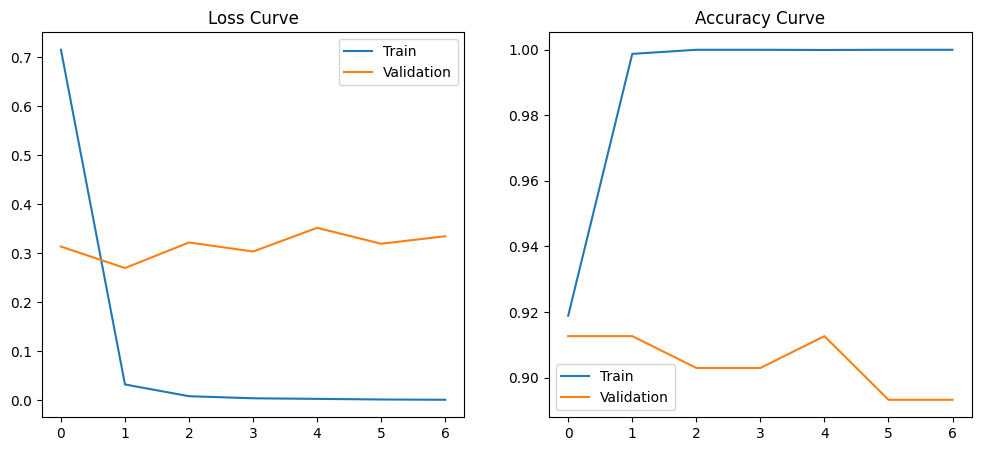

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            
            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

scaler = torch.amp.GradScaler('cuda')
early_stopper = EarlyStopper(patience=5, min_delta=0.001)
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(300):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc = validate(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1:02d}:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}\n")
    
    if early_stopper.early_stop(val_loss):
        print("Early stopping triggered!")
        break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [15]:
save_dir = "/kaggle/working/vit_model"
os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_dir, "vit_model_weights.pth"))

processor.save_pretrained(save_dir)

class_info = {
    "class_order": submission_class_order,
    "class_to_idx": train_dataset.class_to_idx,
    "idx_to_class": {v: k for k, v in train_dataset.class_to_idx.items()}
}

torch.save(class_info, os.path.join(save_dir, "class_info.pth"))

train_config = {
    "epochs_trained": len(history['train_loss']),
    "best_val_acc": max(history['val_acc']),
    "optimizer_state": optimizer.state_dict()
}

torch.save(train_config, os.path.join(save_dir, "train_config.pth"))

print(f"Model Saved to：{save_dir}")

# Second Hugging Face Format Save
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

with open(os.path.join(save_dir, "class_info.txt"), "w") as f:
    f.write("\n".join(submission_class_order))

print("HuggingFace Format Saved")

Model Saved to：/kaggle/working/vit_model
HuggingFace Format Saved


# Test and Generate Submission File

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

class CompetitionTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_files = sorted(os.listdir(test_dir))  # 保持严格顺序
        self.image_paths = [os.path.join(test_dir, f) for f in self.image_files]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(self.image_paths[idx])

def load_trained_model(model_dir, class_order):
    required_files = ['config.json', 'vit_model_weights.pth']
    for f in required_files:
        if not os.path.exists(os.path.join(model_dir, f)):
            raise FileNotFoundError(f"Loss Essential File: {f}")

    config = ViTConfig.from_pretrained(model_dir)
    
    if config.num_labels != len(class_order):
        raise ValueError(f"model classes({config.num_labels})submission requirement({len(class_order)})dismatch")
    
    model = ViTForImageClassification(config).to(device)
    
    model.load_state_dict(
        torch.load(
            os.path.join(model_dir, "vit_model_weights.pth"),
            map_location=device
        )
    )
    
    if config.id2label != {i: cls for i, cls in enumerate(class_order)}:
        print("Warning: The order of categories in the model configuration is inconsistent with the submission requirements, use the submission order to override")
        config.id2label = {i: cls for i, cls in enumerate(class_order)}
        config.label2id = {cls: i for i, cls in enumerate(class_order)}
    
    model.eval()
    return model

def generate_submission(test_dir, model_dir, output_csv="submission.csv"):
    test_dataset = CompetitionTestDataset(test_dir, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
    
    model = load_trained_model(model_dir, submission_class_order)
    
    filenames = []
    predictions = []
    
    with torch.no_grad():
        for images, paths in test_loader:
            outputs = model(images.to(device))
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            
            filenames.extend(paths)
            predictions.extend(batch_preds.tolist())
    
    submission_df = pd.DataFrame({
        'path': filenames,
        'class_idx': predictions
    })
    
    print("\nValidation Results:")
    print(f"Total Samples: {len(submission_df)}")
    print(f"Number of unique file names: {submission_df['path'].nunique()}")
    print(f"Predicted category distribution:\n{submission_df['class_idx'].value_counts().sort_index()}")
    
    submission_df.to_csv(output_csv, index=False)
    print(f"\nModel Saved to: {output_csv}")

if __name__ == "__main__":
    test_dir = "/kaggle/input/bdma-07-competition/BDMA7_project_files/test_images/mistery_cat"
    model_dir = "/kaggle/working/vit_model" 
    
    generate_submission(test_dir, model_dir)

<ipython-input-16-a2806d894222>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(



Validation Results:
Total Samples: 400
Number of unique file names: 400
Predicted category distribution:
class_idx
0     23
1     17
2     22
3     20
4     19
5     19
6     15
7     17
8     19
9     19
10    19
11    18
12    16
13    27
14    21
15    24
16    20
17    19
18    29
19    17
Name: count, dtype: int64

Model Saved to: submission.csv
